# Tutorial 3: Spectral Theorem and unconstrained optimization

Topics:
* Use of <code> numdifftools </code>
* Hessian matrices, definiteness criteria
* eigenvalues
* Solving for stationary points numerically


## Spectral Theorem and definiteness check
### Exercise: Write code to calculate leading principle minors

Define a function <code>LPM()</code> that takes an $m\times m$ matrix $A$ as input and returns a vector with all its leading principle minors $A^{(i)}$ for $i=1\ldots m$ and a vector with the related signs. So:

* input $m\times m$ matrix $A$
* output 1: vector of leading principle minors $A^{(i)}$ for $i=1,\ldots,m$
* output 2: sign vector, with +1,-1,0 indicating positive, negative and zero leading principle minor

As an example, for <code>A=np.array([[1,2],[3,4]])</code> we calculate <code>LPM(A)</code> which delivers the pair <code>array([1.,-2.])</code> and corresponding sign vector <code>[1,-1]</code>.

The sign vector may be compared with known patterns to classify positive definite, negative definite and indefinite matrices. Also, when zeroes arise, we should have a look at all principle minors. This requires a different setup for the algorithm

In [2]:
import numpy as np
import math
import numpy.linalg as la


# Define LPM(A)
# input:   square mxm matrix A as np.array
# output:  dets, (m,) array containing leading principle minors
#          signs, (m,) array with signs of the leading principle minors (np.sign?)

def LPM(A):
    '''Calculates the array of leading principle minors, and the array of signs'''
    # YOUR CODE HERE
    n=A.shape[0]
    dets=[]
    for i in range(1,n+1): #i hate myself for using a for loop... but it's fine
        dets.append(la.det(A[:i,:i]))
    signs= np.sign(dets)
    return dets, signs
    

Check your results with the following code:

In [3]:
A=np.array([[1,2,5],[3,4,6],[4,8,6]])
x, y = LPM(A)
print(f'Leading Principle Minors of \n\n A = \n{A}\n are {x}')
print(f'Sign scheme is {y}')

Leading Principle Minors of 

 A = 
[[1 2 5]
 [3 4 6]
 [4 8 6]]
 are [1.0, -2.0000000000000004, 27.999999999999996]
Sign scheme is [ 1. -1.  1.]


Are the results what you should expect?

Now write code to classify the matrix as positive/negative definite or indefinite. Not all matrices are of this kind, so you may also conclude that you're not sure about the type.

In [4]:
# i didn't like your function so i just deleted it

# Write function check_sign
# input:  output of LPM, that is the vector lpm of all leading principle minors
# output: depending on type print
#         "Positive definite", 
#         "Negative definite", 
#         "Indefinite", or 
#         "Not pos definite/neg definite, maybe indefinite"
def check_sign(lpm):
    _,signs = lpm
    m = len(signs)
    # YOUR CODE HERE
    #ok, i am really close to a more elegant solution, but try using a criteria vector with sth like (1,2,3...) or (-1,2,-3...) and figure out what the dot product tells you.
    if np.sum(signs)==m: 
        print("Positive definite")
    elif np.dot(signs,((np.arange(1,m+1)%2)*2-1))==m:
        print("Negative definite")
    elif np.sum(signs!=0)==m:
        print("Indefinite")
    else:
        print("Not pos definite/neg definite, maybe indefinite")

    print(signs)
    

Play around with the code below to check your code:

In [5]:
A=np.array([[0,1],[1,2]])
check_sign(LPM(A))
np.linalg.eig(A)

Not pos definite/neg definite, maybe indefinite
[ 0. -1.]


(array([-0.41421356,  2.41421356]),
 array([[-0.92387953, -0.38268343],
        [ 0.38268343, -0.92387953]]))

### Determining the principle minors

Below we will present code that you may use to determine all principle minors. 
In order to determine the principle minors of order $k$ of an $m\times m$ matrix $A$, we need to slice $m-k$ rows and the corresponding $m-k$ columns of $A$. How to do this is illustrated here:

In [6]:
A = np.array([[1,2,3],[1,2,4],[1,2,5]])
jojo = np.array((0,2))
A[jojo,jojo]

array([1, 5])

The code below uses <code>itertools</code> to determine for all necessary submatrices the corresponding determinants, i.e., the principle minors. Let's see what <code>itertools</code> may be used for: 

In [7]:
import itertools

stuff = [1, 2, 3]
for L in range(len(stuff) + 1):
    for subset in itertools.combinations(stuff, L):
        print(subset)

()
(1,)
(2,)
(3,)
(1, 2)
(1, 3)
(2, 3)
(1, 2, 3)


Do you see what it does? So we may use it to subset a matrix, what we need for the principle minors. See the code below:

In [8]:
import itertools

def prin_min(matrix):
    stuff = np.arange(1,matrix.shape[0]+1,1)
    detarray=[]
    for L in range(matrix.shape[0]):
        for subset in itertools.combinations(stuff, L):
            #print(subset, 'length=', len(subset))
            npsubset = np.array(subset)-1
            npsubset = npsubset.astype(int)
            #print('subset=',npsubset, 'length=', len(npsubset))
            submat=np.delete(np.delete(matrix, npsubset, axis=0),npsubset,axis=1)
            detarray.append([submat.shape[0],np.linalg.det(submat)])
    return detarray

In [9]:
# Check this..
A = np.array([[1,2,3],[4,5,6],[6,7,9]])
principleminors = np.array(prin_min(A))
print(principleminors)

[[ 3. -3.]
 [ 2.  3.]
 [ 2. -9.]
 [ 2. -3.]
 [ 1.  9.]
 [ 1.  5.]
 [ 1.  1.]]


In [10]:
la.det(A)

-3.0000000000000004

## Unconstrained optimization: application MLE estimation

Below we will focus on a Maximum Likelihood Estimation (MLE). Suppose somebody generates data using the following.

In [11]:
# Create datasets

np.random.seed(10)
mu1, mu2 = -2 , 3 # mean
sigma1, sigma2 = 1, 2 # standard deviation
d1 = np.random.normal(mu1, sigma1, 200) # draws from  X1~N(mu1,sigma_1^2)
d2=np.random.normal(mu2,sigma2,800)     # draws from X2~N(mu1,sigma^2_2)


Now what happens is, that you get the combined data - the vector $d$ below. You only know that there were 200 draws from the distribution $N(\mu_1,\sigma^2_1)$ and 800 draws from the distribution $N(\mu_2,\sigma^2_2)$ with $(\sigma_1,\sigma_2)=(1,2)$. So you know the variances, but not the means. 

In [12]:
d = np.hstack((d1,d2))

In order to get some idea about the dataset you can create a histogram, as follows.

(0.0, 60.0)

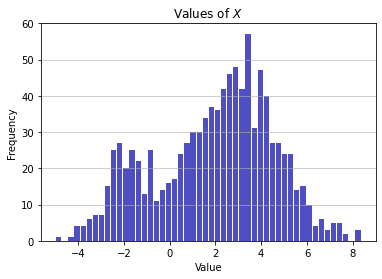

In [13]:
# Create histogram of combined data contained in d
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=d, bins=50, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Values of $X$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

### Maximum Likelihood Estimation

So here you are... you collected data from the realizations of two iid normal distributed random variables $X_1$ and $X_2$ with known standard deviations $\sigma_1=2,\sigma_2=1$, but unknown means. 
Say $X_1\sim N(\mu_1,\sigma_1^2)$ and $X_2\sim N(\mu_2,\sigma_2^2)$. 
You forgot to label what was the measurement about, and that you only know that 20% of the collected data corresponds to $X_1$ whilst 80% corresponds to $X_2$. Can you say something about the means $(\mu_1,\mu_2)$?

The joint pdf of $X$ is given by the weighted pdf's for $X_1$ and $X_2$, i.e., 

$${\displaystyle f_i(x)={\frac {1}{\sigma_i {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu_i }{\sigma_i }}\right)^{2}}}$$

Then the pdf for the mixed distribution is the following

$$f(x\mid \mu_1,\mu_2)=0.2 f_1(x\mid \mu_1,\mu_2)+0.8 f_2(x\mid \mu_1,\mu_2)= \frac{0.2}{\sqrt{2\pi}}e^{-{\frac {1}{2}}\left( {x-\mu_1 }\right)^{2}}+{\frac {0.8}{2 {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu_2 }{2}}\right)^{2}}$$

The likelihood function is the value of the density given the data

$$\mathcal{L}(\mu_1,\mu_2)= \prod_{i=1}^{1000} f(\mu_1,\mu_2\mid x_i).$$ 

Then the log-likelihood function is 

$$\log \mathcal{L}(\mu_1,\mu_2)= \sum_{i=1}^{1000} \log f(\mu_1,\mu_2\mid x_i).$$

Now you want to retrieve the combination of $(\mu_1,\mu_2)$ that is most likely, given the data. In order to do so, MLE tries to find the combination of values $(\mu_1,\mu_2)$ that maximizes the likelihood function $\mathcal{L}$. Of course, this is equivalent with maximizing the log-likelihood function $\log \mathcal{L}$, since $\log$ is a monotone function. Note that this problem is of type 'unconstrained optimization', since there are no restrictions on $(\mu_1,\mu_2)\in\mathbb{R}^2$. 

You will implement this optimization below.

### Intermezzo: Using optimization software: <code>scipy.optimize.minimize</code>

In principle, possible extrema for the likelihood function are calculated by solving for stationary points, via $\nabla \mathcal{L}=0$. Unfortunately, only in special cases you will be able to find analytic results or solve this equation directly. It is more common that you will need a numerical solver. In that case maximizing the log-likelihood function $\log \mathcal{L}$ is preferable due to its additive structure. 

Here you will learn how to use <code>scipy.optimize</code> for this setting. The basic code for unconstrained optimization is highlighted in the examples below. For more details see also:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize



In [14]:
# Example 1: univariate function
from scipy import optimize
def f(x):
    return -np.exp(-(x - 0.7)**2)
result = optimize.minimize_scalar(f)
print(result.success) # check if solver was successful
print(result.x) # the calculated minimum 

True
0.6999999997839409


In [15]:
# Example 2: multivariate functions
def f(x):
    return .5*(1 - x[0])**2 + (x[1] - x[0]**2)**2 # The Rosenbrock function

starting_point = [2,-1] 
optimize.minimize(f, starting_point, method="CG") # Needs specification of starting point and solution method

     fun: 1.6503729082243953e-11
     jac: array([-6.15347610e-06,  2.53804028e-07])
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 13
    njev: 27
  status: 0
 success: True
       x: array([0.99999426, 0.99998863])

In [16]:
# Example 3
def f(x):   # The rosenbrock function
    return .5*(1 - x[0])**2 + (x[1] - x[0]**2)**2
solutions=optimize.minimize(f, [2, -1], method="BFGS")

For more details about the methods that you are adviced to use given the specifications of the problem, see:
https://scipy-lectures.org/advanced/mathematical_optimization/

### Exercise

* Calculate the Hessian matrix for the Rosenbrock function $f$ at the solutions.
* Check that these are indeed in line with a minimum location. 
* What method performs better in this case, 'CG' or 'BFGS'?

In [17]:
# input calculated solutions
# output: classification, output from check_sign

# YOUR CODE HERE
import numdifftools as nd

Hfx=nd.Hessian(f)(solutions.x)
print(Hfx)
check_sign(LPM(Hfx))


[[ 8.99999859 -3.99999962]
 [-3.99999962  2.        ]]
Positive definite
[1. 1.]


Check your answer, did you obtain the following?

In [18]:
hessian = [[ 8.99999868, -3.99999964],
 [-3.99999964,  2.        ]]
signs = [1., 1.]
signature_hessian = 'Positive definite'

In [19]:
assert(np.allclose(hessian,Hfx))

### Exercise: define the objective function

Define the function <code>MLEfunc</code> that you want to minimize in order to maximize the log-likelihood function $\log \mathcal{L}$. Use the data vector $d$ that was created. 

In [20]:
# Objective function
# ml modeling and neg LL calculation
# input:  parameters (mu1,mu2)
# output: -logL(mu1,mu2)

def MLEfunc(parameters,x_values=d):
    # YOUR CODE HERE
    const=np.log(0.2*0.8/((16*np.pi**2)**0.5)) #less computations
    neg_LL=-np.sum(np.vectorize(lambda x: const - 0.5*((x-parameters[0])**2+0.25*((x-parameters[1])**2)))(x_values))
    return neg_LL 
    


In [21]:
import numdifftools as nd
from scipy.optimize import minimize

# Determine gradient and Hessian matrix
MLEgrad=nd.Gradient(MLEfunc)
MLEhess=nd.Hessian(MLEfunc)

# Solve MLE minimization: specify
#                         function, 
#                         intial_guess_of_parameters, 
#                         method
# output mle_model using minimize with starting point [0,0]
# print solution for (mu1,mu2)
# print corresponding function value

# YOUR CODE HERE
sol=optimize.minimize(MLEfunc,[0,0],method="CG")


### Exercise: 

Check the solution you found using <code>minimize</code> using FOC and SOC:

* Value of the gradient at the found optimum
* Hessian and signs of the leading principle minors

In [22]:
# YOUR CODE HERE
print(MLEgrad(sol.x))
print(MLEhess(sol.x))
LPM(MLEhess(sol.x))[1]


[5.68187066e-05 3.80867764e-05]
[[1.00000000e+03 1.67499692e-11]
 [1.67499692e-11 2.50000000e+02]]


array([1., 1.])

It is easy to create a heatmap with contours for this function:

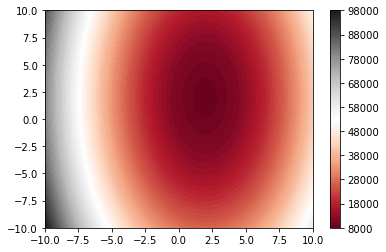

In [23]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(len(x)):
    for j in range(len(y)):
        Z[j,i]=MLEfunc([x[i],y[j]])

plt.contourf(X, Y, Z, 100, cmap='RdGy')
plt.colorbar();

plt.show()


Locator attempting to generate 2980 ticks ([8550.0, ..., 97920.0]), which exceeds Locator.MAXTICKS (1000).


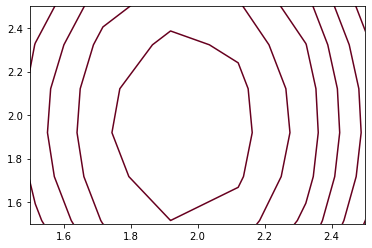

In [24]:

plt.contour(X, Y, Z, 3000, cmap='RdGy')
plt.xlim([1.5,2.5])
plt.ylim([1.5,2.5]);


**Question:** What happens if you use <code>scipy.optimize.minimize</code> with initial values $(\mu^0_1,\mu^0_2)=(7,0)$?

In [81]:
optimize.minimize(MLEfunc,[7,0],method="CG")

     fun: 8555.021986356529
     jac: array([0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 4
    njev: 10
  status: 0
 success: True
       x: array([1.95602536, 1.95602596])

#### Warning, advice

Here a graphical representation helped us figuring out the problem here. When there are more parameters involved, this may be unfeasible. We do not know whether the properties of the minimizing algorithm, together with the properties of our likelihood function, guarantee numerical convergence to the true solution of the problem. Usually, when there is no theoretical guarantee that numerical convergence can be achieved, a multiple starts approach is usually followed: the numerical optimization algorithm is run several times, with random starting values for the parameter, and if all runs of the algorithm (or a majority of them) lead to the same proposed solution, then this is taken as evidence that the proposed solution is a good approximation of the true solution.

